<a href="https://colab.research.google.com/github/huyminh1115/Trip-Advisor-Hotel-Project/blob/main/Code/Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
pip install dask[dataframe]

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from collections import Counter, defaultdict

import string

import nltk
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, f1_score, recall_score, confusion_matrix, classification_report, make_scorer

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import plot

import xgboost
import lightgbm as lgb
sns.set_style('whitegrid')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Exploration

In [6]:
df = pd.read_csv('tripadvisor_hotel_reviews.csv')
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [7]:
df.describe()

,Rating
count,20491.000000
mean,3.952223
std,1.233030
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


## Rating Distribution

<Axes: title={'center': 'Rating Distribution'}, xlabel='Rating'>

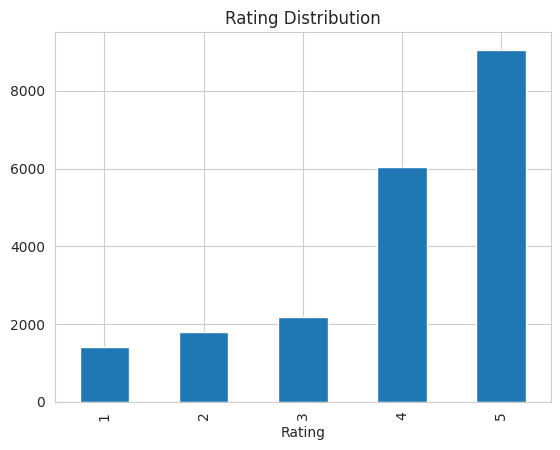

In [8]:
df.groupby('Rating')['Rating'].count().sort_values(ascending=True).plot(kind='bar', title='Rating Distribution')

## Displot length of reviews

In [9]:
# Length of word in sentence
df['Length'] = df['Review'].apply(len)
df.head()

,Review,Rating,Length
0,nice hotel expensive parking got good deal sta...,4,593
1,ok nothing special charge diamond member hilto...,2,1689
2,nice rooms not 4* experience hotel monaco seat...,3,1427
3,"unique, great stay, wonderful time hotel monac...",5,600
4,"great stay great stay, went seahawk game aweso...",5,1281


/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



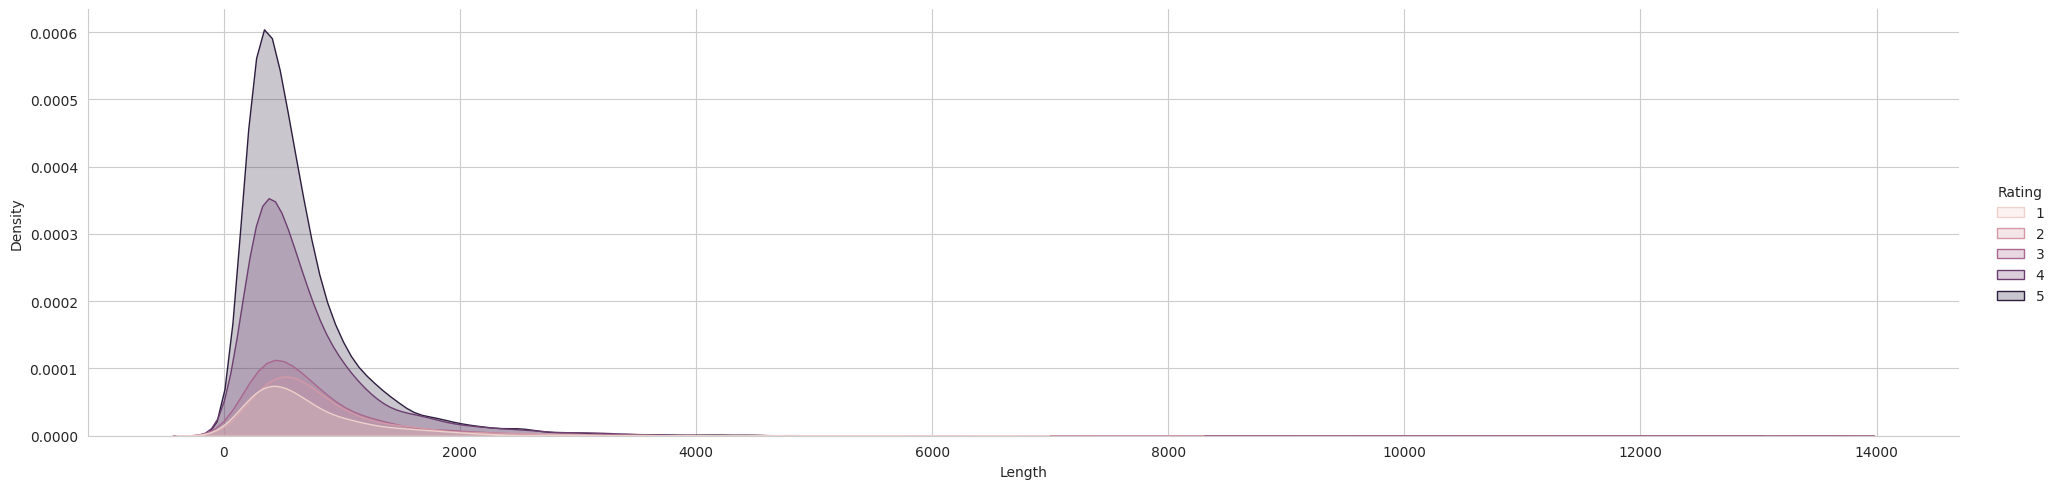

In [10]:
sns.displot(data=df, x='Length', hue='Rating', kind='kde', fill=True, aspect=4)

In [11]:
print('Mean length: ', df['Length'].mean())

Mean length:  724.896832755844


## Word Count

In [12]:
def word_count(review):
    review_list = review.split()
    return len(review_list)

In [13]:
df['Word_count'] = df['Review'].apply(word_count)
df.head(10)

,Review,Rating,Length,Word_count
0,nice hotel expensive parking got good deal sta...,4,593,87
1,ok nothing special charge diamond member hilto...,2,1689,250
2,nice rooms not 4* experience hotel monaco seat...,3,1427,217
3,"unique, great stay, wonderful time hotel monac...",5,600,89
4,"great stay great stay, went seahawk game aweso...",5,1281,191
5,love monaco staff husband stayed hotel crazy w...,5,1002,134
6,"cozy stay rainy city, husband spent 7 nights m...",5,748,101
7,"excellent staff, housekeeping quality hotel ch...",4,597,85
8,"hotel stayed hotel monaco cruise, rooms genero...",5,419,59
9,excellent stayed hotel monaco past w/e delight...,5,271,35


/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



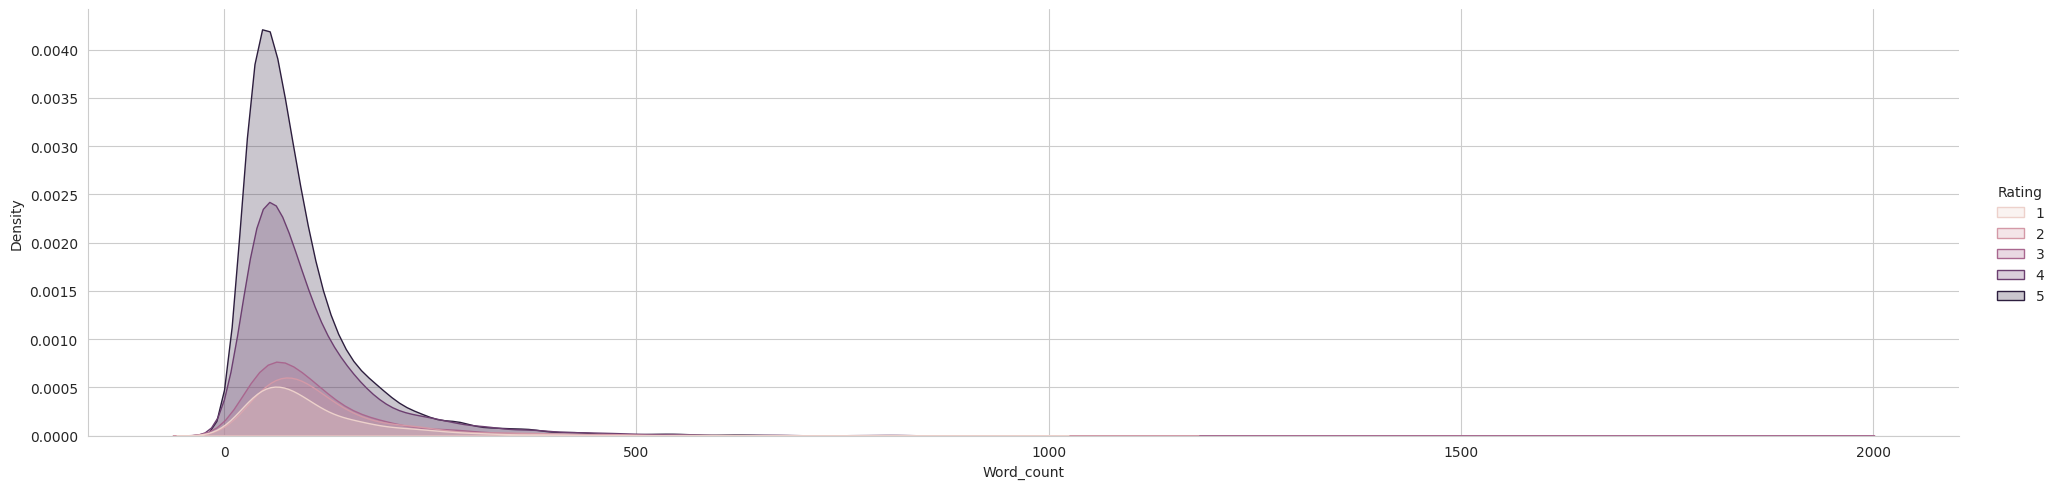

In [14]:
sns.displot(data=df, x='Word_count', hue='Rating', kind='kde', fill=True, aspect=4)

## Word Cloud

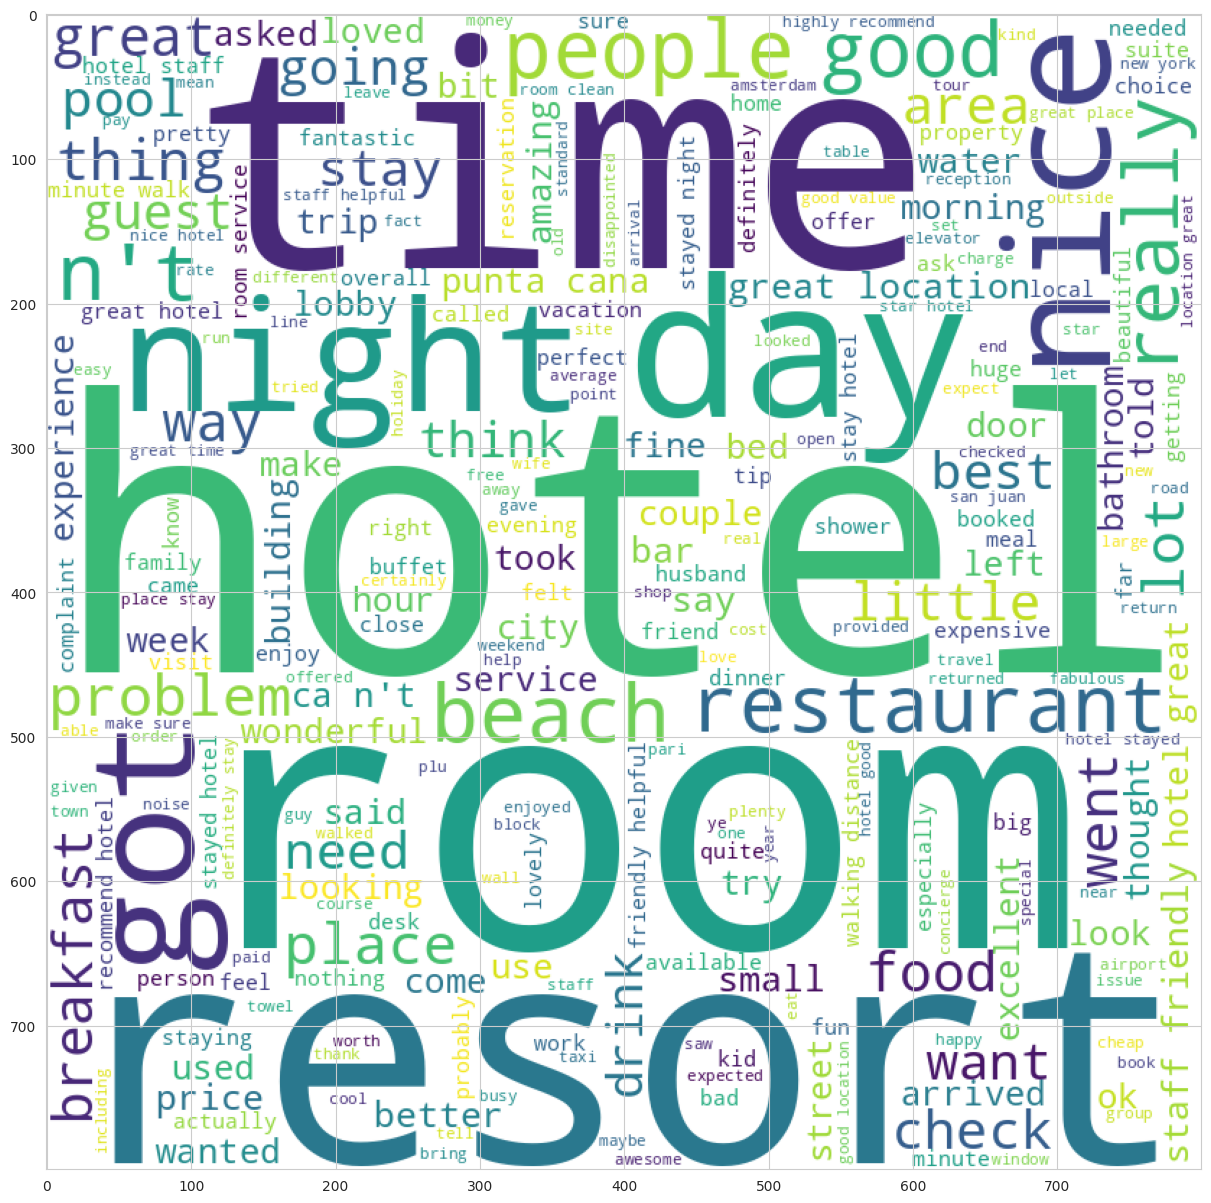

In [15]:
from wordcloud import WordCloud


plt.figure(figsize=(15,15))
wc1 = WordCloud(max_words=1000, min_font_size=10,
                height=800,width=800,background_color="white").generate(' '.join(df['Review']))

plt.imshow(wc1)

# Text Preprocessing

## Remove Stop words

In [16]:
# Define stopwords and punctuation to remove
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

In [17]:
# Instantiate the lemmatizer
lemmatizer = WordNetLemmatizer()

In [18]:
import re

# Combined function to clean and preprocess the text
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove special characters, numbers, and punctuations
    text = re.sub(r'[^a-z\s]', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenize the text
    words = word_tokenize(text)

    # Remove punctuation and stop words, and lemmatize the words
    cleaned_words = [
        lemmatizer.lemmatize(word)
        for word in words
        if word not in stop_words and word not in punctuation
    ]

    # Join the cleaned words back into a single string
    cleaned_text = ' '.join(cleaned_words)

    return cleaned_text

In [19]:
df['cleaned_review'] = df['Review'].apply(preprocess_text)

In [20]:
pd.set_option('display.max_colwidth', None)

In [21]:
df.head(5)

,Review,Rating,Length,Word_count,cleaned_review
0,"nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took advice previous reviews did valet parking, check quick easy, little disappointed non-existent view room room clean nice size, bed comfortable woke stiff neck high pillows, not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway, maybe just noisy neighbors, aveda bath products nice, did not goldfish stay nice touch taken advantage staying longer, location great walking distance shopping, overall nice experience having pay 40 parking night,",4,593,87,nice hotel expensive parking got good deal stay hotel anniversary arrived late evening took advice previous review valet parking check quick easy little disappointed nonexistent view room room clean nice size bed comfortable woke stiff neck high pillow soundproof like heard music room night morning loud bang door opening closing hear people talking hallway maybe noisy neighbor aveda bath product nice goldfish stay nice touch taken advantage staying longer location great walking distance shopping overall nice experience pay parking night
1,"ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle, start booked suite paid extra website description not, suite bedroom bathroom standard hotel room, took printed reservation desk showed said things like tv couch ect desk clerk told oh mixed suites description kimpton website sorry free breakfast, got kidding, embassy suits sitting room bathroom bedroom unlike kimpton calls suite, 5 day stay offer correct false advertising, send kimpton preferred guest website email asking failure provide suite advertised website reservation description furnished hard copy reservation printout website desk manager duty did not reply solution, send email trip guest survey did not follow email mail, guess tell concerned guest.the staff ranged indifferent not helpful, asked desk good breakfast spots neighborhood hood told no hotels, gee best breakfast spots seattle 1/2 block away convenient hotel does not know exist, arrived late night 11 pm inside run bellman busy chating cell phone help bags.prior arrival emailed hotel inform 20th anniversary half really picky wanted make sure good, got nice email saying like deliver bottle champagne chocolate covered strawberries room arrival celebrate, told needed foam pillows, arrival no champagne strawberries no foam pillows great room view alley high rise building good not better housekeeping staff cleaner room property, impressed left morning shopping room got short trips 2 hours, beds comfortable.not good ac-heat control 4 x 4 inch screen bring green shine directly eyes night, light sensitive tape controls.this not 4 start hotel clean business hotel super high rates, better chain hotels seattle,",2,1689,250,ok nothing special charge diamond member hilton decided chain shot th anniversary seattle start booked suite paid extra website description suite bedroom bathroom standard hotel room took printed reservation desk showed said thing like tv couch ect desk clerk told oh mixed suite description kimpton website sorry free breakfast got kidding embassy suit sitting room bathroom bedroom unlike kimpton call suite day stay offer correct false advertising send kimpton preferred guest website email asking failure provide suite advertised website reservation description furnished hard copy reservation printout website desk manager duty reply solution send email trip guest survey follow email mail guess tell concerned guestthe staff ranged indifferent helpful asked desk good breakfast spot neighborhood hood told hotel gee best breakfast spot seattle block away convenient hotel know exist arrived late night pm inside run bellman busy chating cell phone help bagsprior arrival emailed hotel inform th anniversary half really picky wanted make sure good got nice email saying like deliver bottle champa

## Text Analysis

### Term Frequency Analysis

In [22]:
from collections import Counter

# Tokenize the cleaned reviews into words
all_words = ' '.join(df['cleaned_review']).split()

# Count the frequency of each word
word_freq = Counter(all_words)

# Get the most common words
most_common_words = word_freq.most_common(30)

# Convert to a DataFrame for easier visualization
common_words_df = pd.DataFrame(most_common_words, columns=['Word', 'Frequency'])

common_words_df

,Word,Frequency
0,hotel,52957
1,room,46378
2,great,21098
3,nt,19007
4,good,17054
5,staff,16280
6,stay,15341
7,night,14084
8,day,12961
9,time,12611


### Sentiment Analysis

In [24]:
from textblob import TextBlob

# Function to get sentiment score
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

# Apply sentiment analysis to the cleaned reviews
df['sentiment'] = df['cleaned_review'].apply(get_sentiment)

# Display the first few rows to show sentiment scores
df[['cleaned_review', 'sentiment']].head()

,cleaned_review,sentiment
0,nice hotel expensive parking got good deal stay hotel anniversary arrived late evening took advice previous review valet parking check quick easy little disappointed nonexistent view room room clean nice size bed comfortable woke stiff neck high pillow soundproof like heard music room night morning loud bang door opening closing hear people talking hallway maybe noisy neighbor aveda bath product nice goldfish stay nice touch taken advantage staying longer location great walking distance shopping overall nice experience pay parking night,0.208744
1,ok nothing special charge diamond member hilton decided chain shot th anniversary seattle start booked suite paid extra website description suite bedroom bathroom standard hotel room took printed reservation desk showed said thing like tv couch ect desk clerk told oh mixed suite description kimpton website sorry free breakfast got kidding embassy suit sitting room bathroom bedroom unlike kimpton call suite day stay offer correct false advertising send kimpton preferred guest website email asking failure provide suite advertised website reservation description furnished hard copy reservation printout website desk manager duty reply solution send email trip guest survey follow email mail guess tell concerned guestthe staff ranged indifferent helpful asked desk good breakfast spot neighborhood hood told hotel gee best breakfast spot seattle block away convenient hotel know exist arrived late night pm inside run bellman busy chating cell phone help bagsprior arrival emailed hotel inform th anniversary half really picky wanted make sure good got nice email saying like deliver bottle champagne chocolate covered strawberry room arrival celebrate told needed foam pillow arrival champagne strawberry foam pillow great room view alley high rise building good better housekeeping staff cleaner room property impressed left morning shopping room got short trip hour bed comfortablenot good acheat control x inch screen bring green shine directly eye night light sensitive tape controlsthis start hotel clean business hotel super high rate better chain hotel seattle,0.248633
2,nice room experience hotel monaco seattle good hotel nt levelpositives large bathroom mediterranean suite comfortable bed pillowsattentive housekeeping staffnegatives ac unit malfunctioned stay desk disorganized missed separate wakeup call concierge busy hard touch nt provide guidance special requeststv hard use ipod sound dock suite non functioning decided book mediterranean suite night weekend stay st choice rest party filled comparison w spent night larger square footage room great soaking tub whirlpool jet nice showerbefore stay hotel arrange car service price tip reasonable driver waiting arrivalcheckin easy downside room picked person jacuzi tub bath accessory salt bubble bath nt stay night got checked voucher bottle champagne nice gesture fish waiting room impression room huge open space felt room big tv far away bed chore change channel ipod dock broken disappointingin morning way asked desk check thermostat said f degree warm try cover face night bright blue light kept got room night st drop desk called maintainence came look thermostat told play setting happy digital box wo nt work asked wakeup morning nt happen called later pm nap wakeup forgot wakeup morning yep forgottenthe bathroom facility great room surprised room sold whirlpool bath tub nt bath amenity great relax water jet going,0.294420
3,unique great stay wonderful time hotel monaco location excellent short stroll main downtown shopping area pet friendly room showed sign animal hair smell monaco suite sleeping area big striped curtain pulled closed nice touch felt cosy goldfish named brandi enjoyed nt partake free wine coffeetea service lobby thought great feature great staff friendly free wireless internet hotel worked suite laptop decor lovely eclectic mix patten color palatte animal print bathrobe feel like rock star nice nt look 

### Word Cloud with cleaned text

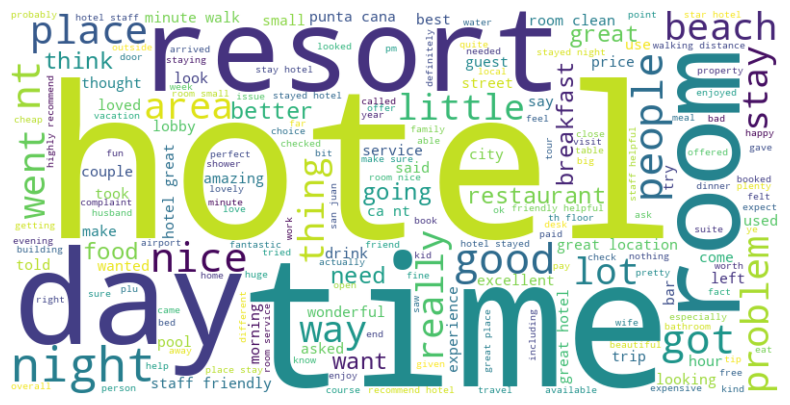

In [25]:
all_reviews = ' '.join(df['cleaned_review'])

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_reviews)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### TF-IDF

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=500)

# Fit and transform the cleaned reviews
tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_review'])

# Convert the TF-IDF matrix to a dataframe for easy viewing
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

tfidf_df.head()

,able,absolutely,access,activity,actually,afternoon,air,airport,amazing,amenity,...,work,worked,working,world,worst,worth,wrong,year,yes,york
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.091646,...,0.072843,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.179195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.096589,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.096238,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Topic Modeling (LDA)

In [27]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Convert the cleaned text data into a document-term matrix
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(df['cleaned_review'])

# Initialize LDA with a reasonable number of topics
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(dtm)

# Get the top words for each topic
n_top_words = 10
words = vectorizer.get_feature_names_out()
topics = {}

for topic_idx, topic in enumerate(lda.components_):
    topics[f"Topic {topic_idx+1}"] = [words[i] for i in topic.argsort()[-n_top_words:]]

# Convert topics to dataFrame
topics_df = pd.DataFrame(topics)

topics_df

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
0,wedding,good,breakfast,pool,time
1,night,nice,night,great,told
2,time,pool,nt,good,night
3,place,stay,stay,time,nt
4,day,service,staff,day,desk
5,room,view,good,food,service
6,pool,restaurant,location,nt,staff
7,hotel,great,great,beach,stay
8,staff,room,room,resort,room
9,great,hotel,hotel,room,hotel


# Word2Vec

In [28]:
!pip install gensim

In [30]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

# Tokenize the text data
df['tokenized_review'] = df['cleaned_review'].apply(word_tokenize)

## Training Word2Vec Model

In [32]:
word2vec_model = Word2Vec(sentences=df['tokenized_review'], vector_size=100, window=5, min_count=2, workers=4)

In [33]:
word_vectors = word2vec_model.wv

In [35]:
similar_words = word_vectors.most_similar('hotel', topn=10)
for similar_word in similar_words:
    print(similar_word)

('property', 0.6070513725280762)
('accommodation', 0.5625548362731934)
('amsterdam', 0.5525339245796204)
('hilton', 0.5359224081039429)
('hotelthe', 0.5250734686851501)
('beijing', 0.5218560099601746)
('radisson', 0.5181019306182861)
('centrally', 0.5153958201408386)
('central', 0.5139169692993164)
('accomodations', 0.5127319097518921)


In [37]:
# Function to get the average word vector for a review
def get_review_vector(review, model):
    word_vectors = [model[word] for word in review if word in model]
    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# Apply the function to the 'tokenized_review' column
df['review_vector'] = df['tokenized_review'].apply(lambda x: get_review_vector(x, word_vectors))

df[['review_vector']].head()

,review_vector
0,"[0.26746067, -0.39511007, 0.2275819, 0.32941934, 0.17896572, -0.12708995, 0.17818813, 0.25732157, -0.5607669, 0.12435533, 0.2672453, -0.027673218, 0.7517806, 0.2934664, 0.16155204, 0.29599524, 0.10778447, 0.08242427, -0.6154333, -0.2184793, 0.15083545, -0.5427124, 0.5475699, -0.019718632, 0.18153122, -0.26544645, -0.42603546, 0.12758914, -0.5767557, 0.53829974, 0.22697648, -0.0891082, 0.5456016, -0.09243433, -0.2842983, 0.3030681, -0.3328203, -0.18052077, 0.21434996, 0.0440628, -0.043796606, -0.48775798, -0.6720763, -0.10411133, 0.50592196, 0.26934472, -0.08314959, -0.04140551, 0.26316056, 0.36437264, -0.268, -0.20274918, -0.111235, -0.5325107, 0.5153317, -0.35466886, -0.4256548, 0.06181755, 0.048792887, 0.4701903, 0.20462318, -0.09510871, 0.30554777, -0.17748009, -0.44206348, 0.41783547, 0.14018515, 0.05300045, -0.35737914, 0.52622265, 0.122982845, -0.19326857, 0.3459905, 0.24459115, 0.30812058, 0.07845409, -0.21170977, -0.43301234, -0.012521963, 0.03647562, 0.5399467, -0.45384598, -0.5810025, 0.54217035, -0.3238504, -0.12889257, 0.2327979, 0.3302039, 0.34277344, -0.14406571, 0.07711907, -0.13466494, 0.48666397, -0.8441288, 0.4720429, 0.27315784, 0.42286855, -0.572392, 0.6103605, -0.66418016]"
1,"[-0.13580382, -0.10084884, -0.06840305, 0.19102025, 0.06551545, -0.43804395, 0.39656714, 0.5206804, -0.36169013, 0.07100802, 0.008284394, 0.079434544, 0.10854338, 0.4552549, 0.11831169, 0.08831531, -0.33146346, -0.2783565, -0.68589693, -0.112734996, -0.06600271, -0.2686955, 0.68010783, 0.14575446, 0.267623, 0.09175444, -0.32961348, -0.18770295, -0.7911279, 0.28678557, 0.38925114, -0.06539421, 0.45651412, 0.12468496, -0.022846056, 0.44135556, -0.03598569, 0.1531443, -0.10491847, 0.0034041912, 0.17056882, -0.16582441, -0.8093017, -0.082426086, 0.30966708, 0.21673435, 0.002596643, 0.37459013, 0.4387139, 0.31243765, -0.23100308, -0.25414076, -0.011058229, -0.6708518, 0.43997186, -0.101463184, -0.30196306, -0.102933325, -0.0699299, 0.38375574, 0.19465962, -0.08458617, -0.09453723, -0.39880365, -0.32310462, 0.35586992, 0.16605625, 0.069025725, -0.23865768, 0.34809804, -0.08241614, -0.22961266, 0.4141969, 0.2465432, 0.06067752, 0.3207628, -0.36337692, -0.5211278, -0.1910635, 0.24690083, 0.40443644, -0.19252753, -0.3381606, 0.25872776, -0.20125625, -0.06812248, 0.41910717, 0.4233588, 0.42463273, 0.07085669, 0.2548892, 0.0029046405, 0.36765566, -0.2615992, 0.47308406, 0.3420621, 0.41551408, -0.301642, 0.5604734, -0.43444547]"
2,"[0.12907822, -0.4086012, 0.0037567795, 0.07770848, 0.0062001455, -0.3174508, 0.35448077, 0.388147, -0.57852507, 0.10669136, 0.24762407, 0.25121802, 0.31561404, 0.5376861, -0.032996684, 0.31689677, 0.01301792, -0.024098866, -0.89764476, -0.04599255, 0.082374126, -0.3421177, 0.56257945, -0.056215655, 0.2817071, 0.050374072, -0.19551104, -0.03180063, -0.5803291, 0.38625017, 0.5467031, -0.10576302, 0.34124598, 0.00458417, -0.091226, 0.3849674, -0.00943262, -0.014533496, 0.11989959, 0.019927107, 0.228893, -0.2904335, -0.5983427, -0.22923465, 0.41850162, -0.011485715, 0.13060041, 0.14417963, 0.4492149, 0.26887593, 0.09945076, -0.27020404, -0.09791586, -0.64798415, 0.24349177, -0.11854974, -0.2646621, 0.24065988, 0.008953416, 0.57469743, 0.050797533, 0.02555314, 0.042872798, -0.29016912, -0.5117066, 0.3757477, 0.14295642, -0.036749918, -0.20026998, 0.41069514, 0.04384566, -0.4728398, 0.32605812, 0.26753223, 0.15293413, -0.10272448, -0.22137603, -0.47139344, -0.118632644, 0.16551314, 0.22562486, -0.15306398, -0.41531357, 0.43288893, -0.27702114, -0.16449778, 0.26383424, 0.31840035, 0.273611, -0.013047275, 0.06714874, -0.033803154, 0.55368274, -0.4009142, 0.37483606, 0.13664661, 0.2820351, -0.36205253, 0.64674485, -0.32846197]"
3,"[0.14176802, -0.31248108, 0.11944489, 0.082050726, -0.066338904, -0.16061208, 0.051812477, 0.15539412, -0.6991436, -0.03934305, 0.09467191, -0.31128758, 0.36131886, 0.41116604, 0.24377577, -0.0931705, 0.108177446, -0.023569211, -0.55725247, -0.0025587426, 0.036539663, -0.31605574, 0

In [39]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute similarity between the first two reviews
similarity = cosine_similarity([df['review_vector'].iloc[0]], [df['review_vector'].iloc[1]])
print(similarity)

[[0.8041773]]


In [42]:
word2vec_model.save("/content/drive/MyDrive/Colab Notebooks/word2vec_hotel_reviews.model")